# Introduction To Joint Probability Tests

In this notebook, we verify the various functions used to compute information theoretic properties of the binary markov upstream system. Specifically, we cover:

- Steady State Distribution Results (Numerical integration, Gillespie Simulation)
- Analytical Solutions for Joint Probability Distributions Vs ODE Numerical Integration
- Gillespie Simulation Results and Entropy Calculations

These functions are packaged into 'binary_markov_funcs.py' for later use.

# Steady State Distribution Tests

## Analytical Time-Dependent Solution vs Numerical Integration

An example of numerically integrating the binary markovian system to obtain the steady state distribution, as well as a comparison with the analytical time-dependent distribution.

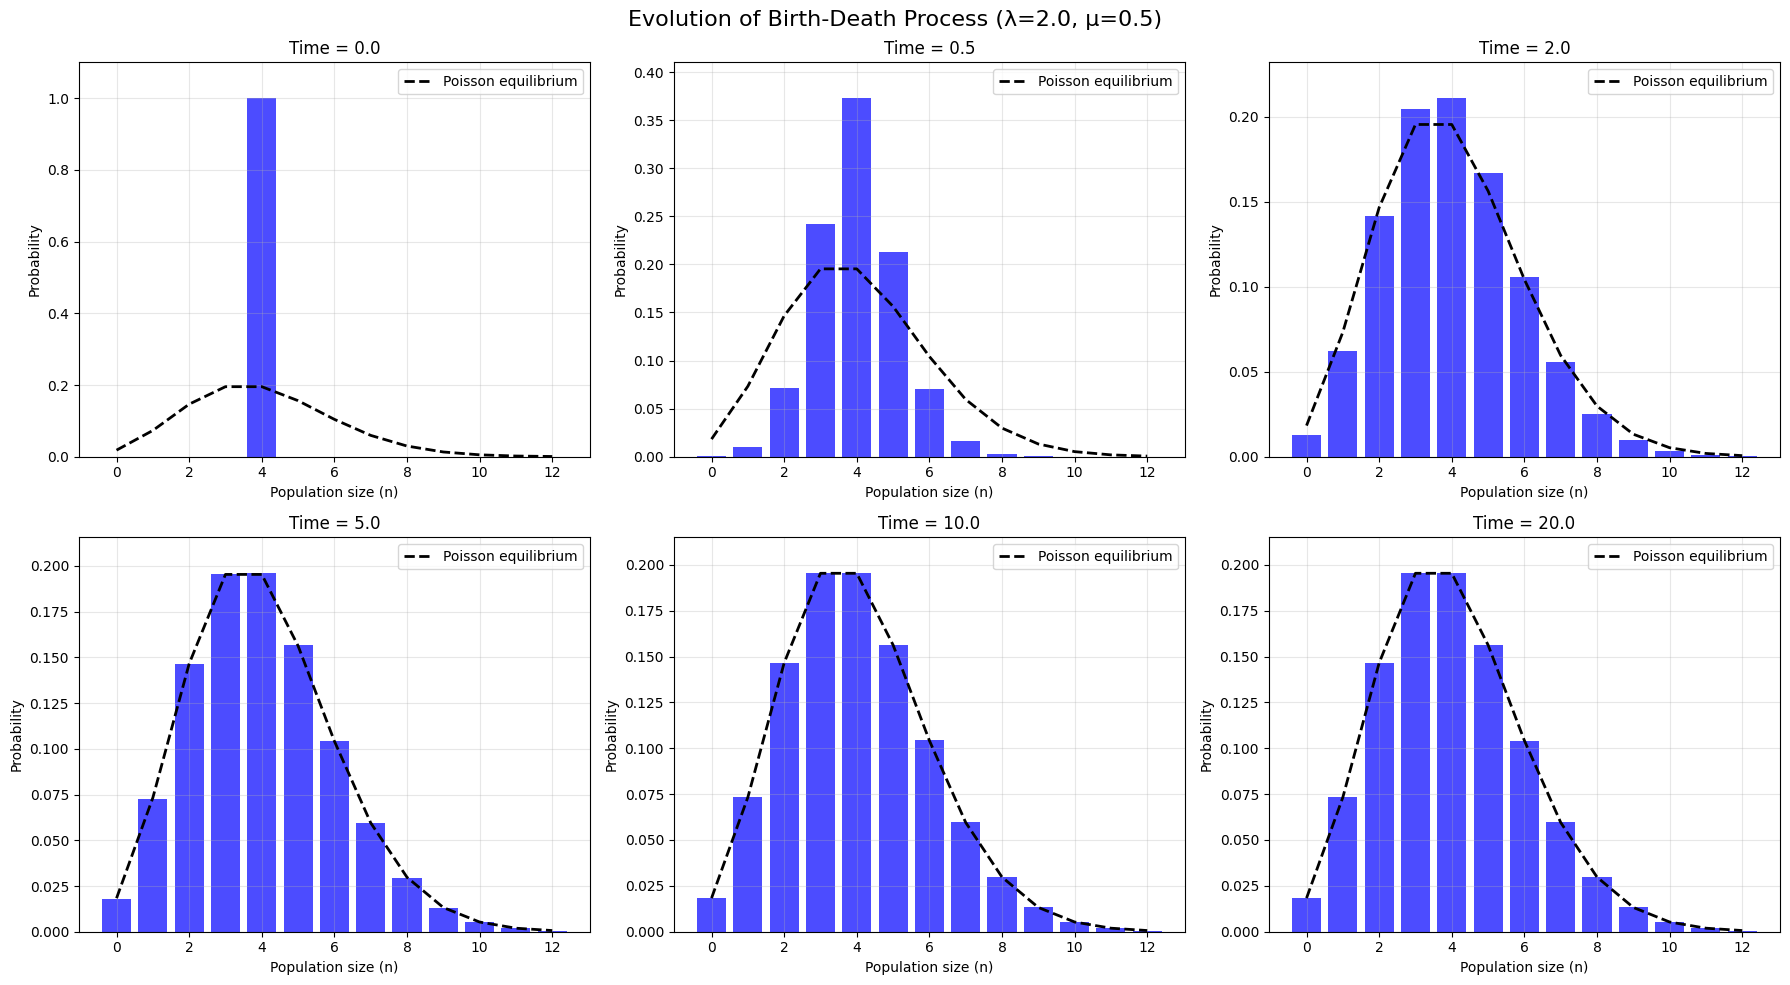

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import factorial

# Define parameters
λ = 2.0  # Birth rate (constant)
μ = 0.5  # Death rate (per individual)

# Calculate equilibrium mean
mean = λ / μ
max_n = int(3 * mean)  # Truncate the system at 3 times the mean

# Initial conditions - all probability concentrated at the mean
P0 = np.zeros(max_n + 1)
P0[int(mean)] = 1.0

# Time range - run for long enough to reach equilibrium
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 100)
snapshot_times = [0, 0.5, 2, 5, 10, t_span[1]]  # More time points to show evolution

# System of ODEs for birth-death process
def birth_death_system(t, p, λ, μ, max_n):
    dpdt = np.zeros_like(p)
    
    # Handle boundary cases
    dpdt[0] = μ * p[1] - λ * p[0]
    dpdt[max_n] = λ * p[max_n-1] - μ * max_n * p[max_n]
    
    # General case
    for n in range(1, max_n):
        dpdt[n] = λ * p[n-1] + μ * (n+1) * p[n+1] - (λ + μ * n) * p[n]
    
    return dpdt

# Solve the ODEs numerically
sol = solve_ivp(birth_death_system, t_span, P0, t_eval=t_eval, 
                args=(λ, μ, max_n), method='RK45', vectorized=False)

# Find indices of snapshot times
snapshot_indices = [np.argmin(np.abs(t_eval - t)) for t in snapshot_times]

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Evolution of Birth-Death Process (λ={λ}, μ={μ})', fontsize=16)

# Theoretical equilibrium distribution (Poisson)
n_values = np.arange(0, max_n + 1)
poisson_dist = np.exp(-mean) * (mean**n_values) / factorial(n_values)

# Plot each snapshot in its own subplot
for i, (idx, t) in enumerate(zip(snapshot_indices, snapshot_times)):
    ax = axes[i//3, i%3]
    ax.bar(n_values, sol.y[:, idx], alpha=0.7, color='steelblue', width=0.8)
    ax.plot(n_values, poisson_dist, 'r--', lw=1.5, label='Poisson equilibrium')
    
    ax.set_title(f'Time = {t:.1f}', fontsize=12)
    ax.set_xlabel('Population size (n)', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.set_ylim([0, 1.1*max(sol.y[:, idx].max(), poisson_dist.max())])
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig("birth_death_evolution_subplots.png")
plt.show()

# Analytical Solutions for Poisson Joint Probability Distribution

a

(21, 300, 21)


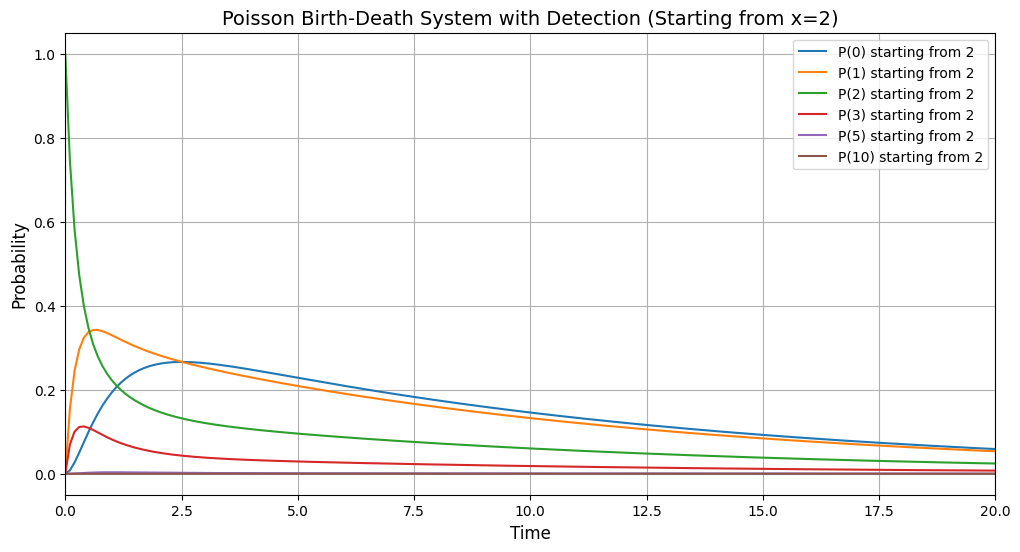

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import factorial

# Poisson Birth-Death ODE system with detection
def poisson_birth_death_detection_dt(t, p, λ, μ, α, max_n):
    dpdt = np.zeros_like(p)
    
    # Boundary cases
    dpdt[0] = μ * p[1] - λ * p[0]  # n=0
    dpdt[-1] = λ * p[-2] - (μ * (max_n) + α * max_n) * p[-1]  # n=max_n
    
    # General case
    for n in range(1, max_n):
        dpdt[n] = (λ * p[n-1] + μ * (n+1) * p[n+1] - 
                  (λ + μ * n + α * n) * p[n])
    return dpdt

def poisson_survival_probabilities(survival_diffeq, num_states, t_max, dt, λ, μ, α):
    t_eval = np.arange(0, t_max, dt)
    num_time_points = len(t_eval)
    solution = np.zeros((num_states, num_time_points, num_states))
    max_n = num_states - 1
    
    for initial_state in range(num_states):
        initial_p = np.zeros(num_states)
        initial_p[initial_state] = 1.0
        sol = solve_ivp(survival_diffeq, [0, t_max], initial_p, 
                   t_eval=t_eval, method='RK45', args=(λ, μ, α, max_n))
        solution[initial_state, :, :] = sol.y.T
    
    return solution

# Define parameters
λ = 1.0  # Birth rate
μ = 1.0  # Death rate
α = 0.1  # Detection rate (per individual)

# Time parameters
t_max = 30
dt = 0.1

# System size (truncate at reasonable maximum)
max_n = 20
num_states = max_n + 1

# Compute survival probabilities starting from x=1
solution = poisson_survival_probabilities(
    poisson_birth_death_detection_dt, num_states, t_max, dt, λ, μ, α )
print (solution.shape)

t_eval = np.arange(0, t_max, dt)
init_cond_plot = 2

# Plot some selected states
plt.figure(figsize=(12, 6))
for n in [0, 1, 2, 3, 5, 10]:
    plt.plot(t_eval, solution[init_cond_plot, :, n], label=f'P({n}) starting from '+str(init_cond_plot))

plt.xlabel('Time', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Poisson Birth-Death System with Detection (Starting from x='+str(init_cond_plot)+')', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.xlim(0, 20)
plt.show()
